In [1]:
import pymongo as pm
from pymongo import MongoClient
from bson import Code
# client = MongoClient('localhost', 27017)
client = MongoClient('mongodb://localhost:27017/')
stockDB = client.stock
companyDB = client.companyData
stockCol = stockDB.stocks
companyCol = companyDB.companies

import warnings
warnings.filterwarnings('ignore')

In [2]:
stockCol.find_one()

{'_id': ObjectId('4d094f58c96767d7a0099d49'),
 'exchange': 'NASDAQ',
 'stock_symbol': 'AACC',
 'date': '2008-03-07',
 'open': 8.4,
 'high': 8.75,
 'low': 8.08,
 'close': 8.55,
 'volume': 275800,
 'adj close': 8.55}

In [9]:
#lets find the top 10 high valued stock at all time and its highest value

#db.stocks.find().sort({'high':-1}).limit(10)

list(stockCol.find({}, {'stock_symbol':1, 'high':1, 'date':1, "_id":0}).sort([('high', -1)]).limit(10))

[{'stock_symbol': 'BORD', 'date': '2000-09-21', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-08-03', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-25', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-13', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-20', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-22', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-07-12', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-21', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-13', 'high': 7500.0},
 {'stock_symbol': 'BORD', 'date': '2000-09-25', 'high': 7500.0}]

The result is quite not what we want. Let's reframe the query

In [15]:
list(stockCol.aggregate([
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1}},
    {"$group": {"_id": "$stock_symbol", "value": {"$max" : "$high"}, "vol" : {"$max" : "$volume"}}},
    {"$sort": {"value" : -1}},
    {"$limit": 10}
]))

[{'_id': 'BORD', 'value': 7500.0, 'vol': 162200},
 {'_id': 'AHCI', 'value': 762.78, 'vol': 4702900},
 {'_id': 'GOOG', 'value': 747.24, 'vol': 41116700},
 {'_id': 'DCAP', 'value': 593.0, 'vol': 94800},
 {'_id': 'MITSY', 'value': 540.69, 'vol': 73700},
 {'_id': 'YHOO', 'value': 500.13, 'vol': 438248800},
 {'_id': 'BIDU', 'value': 429.19, 'vol': 22681100},
 {'_id': 'FARM', 'value': 393.94, 'vol': 748000},
 {'_id': 'ARBA', 'value': 366.69, 'vol': 31150800},
 {'_id': 'AMZN', 'value': 361.88, 'vol': 104329200}]

Thus we get the required result using aggregate pipeline which is one of MongoDB powerful feature. We have applied group by on stock symbol and then we took the highest value. It's highly useful. Let's say we want to find out top 10 based on volume

In [14]:
stockCol.distinct('exchange')

['NASDAQ']

In [17]:
list(stockCol.aggregate([
    {"$match": {"volume" : {"$gt": 1000000}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1}},
    {"$group": {"_id": "$stock_symbol", "value": {"$max" : "$high"}, "vol" : {"$max" : "$volume"}}},
    {"$sort": {"value" : -1}},
    {"$limit": 10}
]))

[{'_id': 'GOOG', 'value': 747.24, 'vol': 41116700},
 {'_id': 'YHOO', 'value': 500.13, 'vol': 438248800},
 {'_id': 'BIDU', 'value': 429.19, 'vol': 22681100},
 {'_id': 'ARBA', 'value': 366.69, 'vol': 31150800},
 {'_id': 'AMZN', 'value': 361.88, 'vol': 104329200},
 {'_id': 'BRCM', 'value': 354.88, 'vol': 70552200},
 {'_id': 'EBAY', 'value': 354.25, 'vol': 243139200},
 {'_id': 'BRCD', 'value': 352.63, 'vol': 75128800},
 {'_id': 'FDRY', 'value': 345.0, 'vol': 35709200},
 {'_id': 'AFFX', 'value': 327.0, 'vol': 19405300}]

In [18]:
#top 10 stocks with high volume

list(stockCol.aggregate([
    {"$match": {"volume" : {"$gt": 1000000}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1}},
    {"$group": {"_id": "$stock_symbol", "value": {"$max" : "$high"}, "vol" : {"$max" : "$volume"}}},
    {"$sort": {"vol" : -1}},
    {"$limit": 10}
]))

[{'_id': 'MSFT', 'value': 180.38, 'vol': 1031788800},
 {'_id': 'DELL', 'value': 173.5, 'vol': 842560000},
 {'_id': 'CSCO', 'value': 146.75, 'vol': 806732800},
 {'_id': 'YHOO', 'value': 500.13, 'vol': 438248800},
 {'_id': 'AMGN', 'value': 166.5, 'vol': 309017200},
 {'_id': 'ETFC', 'value': 144.5, 'vol': 295015700},
 {'_id': 'AAPL', 'value': 202.96, 'vol': 265069000},
 {'_id': 'AMAT', 'value': 196.94, 'vol': 245245600},
 {'_id': 'EBAY', 'value': 354.25, 'vol': 243139200},
 {'_id': 'NVDA', 'value': 176.0, 'vol': 230771400}]

In [125]:
#Though Microsoft stock value is less, net value (value * volume) seems to be higher. So lets create a field to check
list(stockCol.aggregate([
    {"$match": {"volume" : {"$gt": 1000000}}},
    {"$addFields" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$group": {"_id": "$stock_symbol", "value": {"$max" : "$high"}, "vol" : {"$max" : "$volume"},
                "nvol" : {"$max" : "$netValue"}}},
    {"$sort": {"nvol" : -1}},
    {"$limit": 10},
    {"$out" : "topStocks"}
]))


[]

In [126]:
topstocks = stockDB.topStocks
list(topstocks.find())

[{'_id': 'YHOO', 'value': 500.13, 'vol': 438248800, 'nvol': 93665726000.0},
 {'_id': 'MSFT', 'value': 180.38, 'vol': 1031788800, 'nvol': 47321280000.0},
 {'_id': 'DELL', 'value': 173.5, 'vol': 842560000, 'nvol': 46870539200.0},
 {'_id': 'EBAY', 'value': 354.25, 'vol': 243139200, 'nvol': 41834091000.0},
 {'_id': 'AMGN', 'value': 166.5, 'vol': 309017200, 'nvol': 33682874800.0},
 {'_id': 'AMZN', 'value': 361.88, 'vol': 104329200, 'nvol': 30717305100.0},
 {'_id': 'CSCO', 'value': 146.75, 'vol': 806732800, 'nvol': 30399516000.0},
 {'_id': 'GOOG', 'value': 747.24, 'vol': 41116700, 'nvol': 18092581501.0},
 {'_id': 'AAPL', 'value': 202.96, 'vol': 265069000, 'nvol': 16864848000.0},
 {'_id': 'BRCM', 'value': 354.88, 'vol': 70552200, 'nvol': 15284817450.0}]

We can add fields on the fly and even we can output the items as another collection. This will be good for batch processing. Out will simply drop the existing collection and create a new one. See below for the behaviour. If we want to append the results to an existing collection, then we can use merge instead of out.

In [131]:
list(stockCol.aggregate([
    {"$match": {"volume" : {"$gt": 1000000}}},
    {"$addFields" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$group": {"_id": "$stock_symbol", "value": {"$max" : "$high"}, "vol" : {"$max" : "$volume"},
                "nvol" : {"$max" : "$netValue"}}},
    {"$sort": {"nvol" : -1}},
    {"$skip":10},
    {"$limit": 10},
    { "$merge" : { "into": "topStocks", "whenMatched": "replace" } }
]))

[]

In [132]:
list(topstocks.find())

[{'_id': 'YHOO', 'value': 500.13, 'vol': 438248800, 'nvol': 93665726000.0},
 {'_id': 'MSFT', 'value': 180.38, 'vol': 1031788800, 'nvol': 47321280000.0},
 {'_id': 'DELL', 'value': 173.5, 'vol': 842560000, 'nvol': 46870539200.0},
 {'_id': 'EBAY', 'value': 354.25, 'vol': 243139200, 'nvol': 41834091000.0},
 {'_id': 'AMGN', 'value': 166.5, 'vol': 309017200, 'nvol': 33682874800.0},
 {'_id': 'AMZN', 'value': 361.88, 'vol': 104329200, 'nvol': 30717305100.0},
 {'_id': 'CSCO', 'value': 146.75, 'vol': 806732800, 'nvol': 30399516000.0},
 {'_id': 'GOOG', 'value': 747.24, 'vol': 41116700, 'nvol': 18092581501.0},
 {'_id': 'AAPL', 'value': 202.96, 'vol': 265069000, 'nvol': 16864848000.0},
 {'_id': 'BRCM', 'value': 354.88, 'vol': 70552200, 'nvol': 15284817450.0},
 {'_id': 'AMAT', 'value': 196.94, 'vol': 245245600, 'nvol': 12071758000.0},
 {'_id': 'COMS', 'value': 119.75, 'vol': 116886000, 'nvol': 11764080774.0},
 {'_id': 'NVDA', 'value': 176.0, 'vol': 230771400, 'nvol': 9056880000.0},
 {'_id': 'GILD', 

whenMatched will default look for '_id' unless we specify other fields to check using 'on'. We can keep existing instead of replace or even merge (default) which update the existing doc if there're new fields.

More here https://docs.mongodb.com/manual/reference/operator/aggregation/merge/

In [31]:
#Below code is a way to acheive row number and it selects the top 5 volumes for 'GOOG'.

list(stockCol.aggregate([
    {"$match": {"stock_symbol" : "GOOG"}},
    {"$addFields" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$sort": {"netValue" : -1}},
    {"$group" : {"_id" : "$stock_symbol", "nvolvalues" : {"$push": "$netValue"}}},
    {"$unwind" : {"path": "$nvolvalues", "includeArrayIndex": "rank"}},
    {"$match" : {"rank": {"$lte" : 4}}}
]))

[{'_id': 'GOOG', 'nvolvalues': 18092581501.0, 'rank': 0},
 {'_id': 'GOOG', 'nvolvalues': 15678023504.0, 'rank': 1},
 {'_id': 'GOOG', 'nvolvalues': 14311641018.0, 'rank': 2},
 {'_id': 'GOOG', 'nvolvalues': 12134650658.0, 'rank': 3},
 {'_id': 'GOOG', 'nvolvalues': 10903245000.0, 'rank': 4}]

Of course, we can do this simple sort instead of group by, now think we want to do it for 3 stocks. Also unwind basically creates a document for every element in an array while wind operator does the opposite

In [33]:
list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : ["GOOG", "MSFT", "DELL"]}}},
    {"$addFields" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$sort": {"netValue" : -1}},
    {"$group" : {"_id" : "$stock_symbol", "nvolvalues" : {"$push": "$netValue"}}},
    {"$unwind" : {"path": "$nvolvalues", "includeArrayIndex": "rank"}},
    {"$match" : {"rank": {"$lte" : 4}}}
]))

[{'_id': 'DELL', 'nvolvalues': 46870539200.0, 'rank': 0},
 {'_id': 'DELL', 'nvolvalues': 38668852800.0, 'rank': 1},
 {'_id': 'DELL', 'nvolvalues': 29771560000.0, 'rank': 2},
 {'_id': 'DELL', 'nvolvalues': 28116304000.0, 'rank': 3},
 {'_id': 'DELL', 'nvolvalues': 26512491040.0, 'rank': 4},
 {'_id': 'GOOG', 'nvolvalues': 18092581501.0, 'rank': 0},
 {'_id': 'GOOG', 'nvolvalues': 15678023504.0, 'rank': 1},
 {'_id': 'GOOG', 'nvolvalues': 14311641018.0, 'rank': 2},
 {'_id': 'GOOG', 'nvolvalues': 12134650658.0, 'rank': 3},
 {'_id': 'GOOG', 'nvolvalues': 10903245000.0, 'rank': 4},
 {'_id': 'MSFT', 'nvolvalues': 47321280000.0, 'rank': 0},
 {'_id': 'MSFT', 'nvolvalues': 41764853520.0, 'rank': 1},
 {'_id': 'MSFT', 'nvolvalues': 34329355200.0, 'rank': 2},
 {'_id': 'MSFT', 'nvolvalues': 31024522880.0, 'rank': 3},
 {'_id': 'MSFT', 'nvolvalues': 30921408000.0, 'rank': 4}]

We can also pass empty strings to group by id which in the above case prints out overall high net values. Notice we can pass more than one field in push operator.

In [39]:
list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : ["GOOG", "MSFT", "DELL"]}}},
    {"$addFields" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$sort": {"netValue" : -1}},
    {"$group" : {"_id" : "", "nvolvalues" : {"$push": {"nv" : "$netValue", "stock": "$stock_symbol"}}}},
    {"$unwind" : {"path": "$nvolvalues", "includeArrayIndex": "rank"}},
    {"$match" : {"rank": {"$lte" : 10}}},
    {"$unset" : ["_id"]}
]))

[{'nvolvalues': {'nv': 47321280000.0, 'stock': 'MSFT'}, 'rank': 0},
 {'nvolvalues': {'nv': 46870539200.0, 'stock': 'DELL'}, 'rank': 1},
 {'nvolvalues': {'nv': 41764853520.0, 'stock': 'MSFT'}, 'rank': 2},
 {'nvolvalues': {'nv': 38668852800.0, 'stock': 'DELL'}, 'rank': 3},
 {'nvolvalues': {'nv': 34329355200.0, 'stock': 'MSFT'}, 'rank': 4},
 {'nvolvalues': {'nv': 31024522880.0, 'stock': 'MSFT'}, 'rank': 5},
 {'nvolvalues': {'nv': 30921408000.0, 'stock': 'MSFT'}, 'rank': 6},
 {'nvolvalues': {'nv': 30179822400.0, 'stock': 'MSFT'}, 'rank': 7},
 {'nvolvalues': {'nv': 30127914000.0, 'stock': 'MSFT'}, 'rank': 8},
 {'nvolvalues': {'nv': 29771560000.0, 'stock': 'DELL'}, 'rank': 9},
 {'nvolvalues': {'nv': 29026785152.0, 'stock': 'MSFT'}, 'rank': 10}]

In [42]:
#unset removes the fields from the result and we can use set instead of addFields

list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : ["GOOG", "MSFT", "DELL"]}}},
    {"$set" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1}},
    {"$sort": {"netValue" : -1}},
    {"$group" : {"_id" : "", "nvolvalues" : {"$push": {"nv" : "$netValue", "stock": "$stock_symbol"}}}},
    {"$unwind" : {"path": "$nvolvalues", "includeArrayIndex": "rank"}},
    {"$match" : {"rank": {"$lte" : 10}}},
    {"$unset" : ["_id", "nvolvalues.stock", "rank"]}
]))

[{'nvolvalues': {'nv': 47321280000.0}},
 {'nvolvalues': {'nv': 46870539200.0}},
 {'nvolvalues': {'nv': 41764853520.0}},
 {'nvolvalues': {'nv': 38668852800.0}},
 {'nvolvalues': {'nv': 34329355200.0}},
 {'nvolvalues': {'nv': 31024522880.0}},
 {'nvolvalues': {'nv': 30921408000.0}},
 {'nvolvalues': {'nv': 30179822400.0}},
 {'nvolvalues': {'nv': 30127914000.0}},
 {'nvolvalues': {'nv': 29771560000.0}},
 {'nvolvalues': {'nv': 29026785152.0}}]

In [48]:
#lets suppose you want to write a query which describes a stock

stock_in_interest = ["GOOG", "MSFT", "DELL"]

list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$set" : {"netValue" : {"$multiply" : ["$volume", "$high"]}}},
    {"$project": {'stock_symbol':1, 'high':1, "_id":0, 'volume':1, "netValue":1, "date":1}},
    {"$group" : {"_id" : "$stock_symbol", "avgNV" : {"$avg": "$netValue"},"avgVol" : {"$avg": "$volume"}, 
                 "avgHigh" : {"$avg": "$high"}, "lowValue": {"$min": "$high"},"highValue": {"$max": "$high"},
                "recentDate": {"$max": "$date"}}}
]))

[{'_id': 'GOOG',
  'avgNV': 3053467214.0067115,
  'avgVol': 8302865.77181208,
  'avgHigh': 393.86317673378073,
  'lowValue': 101.74,
  'highValue': 747.24,
  'recentDate': '2008-03-07'},
 {'_id': 'DELL',
  'avgNV': 2272170288.8586493,
  'avgVol': 48528628.06732914,
  'avgHigh': 37.52595619549787,
  'lowValue': 4.88,
  'highValue': 173.5,
  'recentDate': '2008-03-07'},
 {'_id': 'MSFT',
  'avgNV': 4896945205.074287,
  'avgVol': 68975653.7865128,
  'avgHigh': 70.16791922106023,
  'lowValue': 21.94,
  'highValue': 180.38,
  'recentDate': '2008-03-07'}]

In [95]:
#recent stock values
stock_in_interest = ["GOOG", "MSFT", "DELL"]

list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$sort" : {"date" : -1}},
    {"$group" : {"_id" : "$stock_symbol" , "details" : {"$push" : {"vol" : "$volume", "high": "$high", "date" : "$date"}}}},
    {"$unwind" : {"path" : "$details", "includeArrayIndex": "rank"}},
    {"$match" : {"rank" : 0}}
]))

[{'_id': 'MSFT',
  'details': {'vol': 77597600, 'high': 28.07, 'date': '2008-03-07'},
  'rank': 0},
 {'_id': 'GOOG',
  'details': {'vol': 8071800, 'high': 440.0, 'date': '2008-03-07'},
  'rank': 0},
 {'_id': 'DELL',
  'details': {'vol': 29335600, 'high': 19.91, 'date': '2008-03-07'},
  'rank': 0}]

In [97]:
#another way of doing the above 

stock_in_interest = ["GOOG", "MSFT", "DELL"]

list(stockCol.aggregate([
    {"$match": {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$sort" : {"date" : -1}},
    {"$group" : {"_id" : "$stock_symbol" , "vol" : {"$first" : "$volume"}, "date" : { "$first" : "$date"},
                 "high" : { "$first" : "$high"}}}
]))

[{'_id': 'DELL', 'vol': 29335600, 'date': '2008-03-07', 'high': 19.91},
 {'_id': 'MSFT', 'vol': 77597600, 'date': '2008-03-07', 'high': 28.07},
 {'_id': 'GOOG', 'vol': 8071800, 'date': '2008-03-07', 'high': 440.0}]

This may give you a good idea of how sorting before groupby helps in further stages

In [51]:
list(companyCol.aggregate([
    {"$group": {"_id": "", "minYear" : {"$min" : "$founded_year"}, "maxYear" : {"$max" : "$founded_year"}}}
]))

[{'_id': '', 'minYear': 1800, 'maxYear': 2013}]

In [56]:
list(companyCol.aggregate([
    {
    "$bucket": {"groupBy": "$founded_year", "boundaries": [ 1000,1800, 1850, 1875, 1900, 1950, 1975,2000,2025 ],
      "default": "Other", 
      "output": { "count": { "$sum": 1 }}}
    }
]))

[{'_id': 1800, 'count': 19},
 {'_id': 1850, 'count': 12},
 {'_id': 1875, 'count': 26},
 {'_id': 1900, 'count': 82},
 {'_id': 1950, 'count': 134},
 {'_id': 1975, 'count': 2121},
 {'_id': 2000, 'count': 10742},
 {'_id': 'Other', 'count': 5665}]

In [99]:
#now suppose you want to find the companies found before 2000 and after 2000. You could write two separate queries or introduce a new filed

list(companyCol.aggregate([
    {"$set" : {"newCompany" : {"$cond" : {"if" : {"$gte" : ["$founded_year", 2000]}, "then" : True, "else" : False}}}},
    {"$group" : {"_id" : "$newCompany", "count" : {"$sum" : 1}}}
]))


[{'_id': True, 'count': 10742}, {'_id': False, 'count': 8059}]

In [123]:

list(companyCol.aggregate([
    {"$match" : {"founded_year" : {"$ne": None}}},
    {"$set" : {"newCompany" : {"$cond" : {"if" : {"$gte" : ["$founded_year", 2000]}, "then" : True, "else" : False}}}},
    {"$group" : {"_id" : "$newCompany", "count" : {"$sum" : 1}}}
]))


[{'_id': True, 'count': 10742}, {'_id': False, 'count': 2394}]

In [ ]:
list(companyCol.aggregate([
    {"$match" : {"founded_year" : {"$ne": None}}},
    {"$set" : {"newCompany" : {"$cond" : {"if" : {"$gte" : ["$founded_year", 2000]}, "then" : True, "else" : False}}}},
    {"$group" : {"_id" : "$newCompany", "count" : {"$sum" : 1}}}
]))

In [104]:
#bit more complex cond

list(companyCol.aggregate([
    {"$match" : {"founded_year" : {"$ne": None}}},
    {"$set" : {"newCompany" : {"$cond" : {"if" : { "$and" : [{"$gte" : ["$founded_year", 2000]},
                                                            {"$lte" : ["$number_of_employees", 50]}]},
                                          "then" : True, "else" : False}}}},
    {"$group" : {"_id" : "$newCompany", "count" : {"$sum" : 1}}}
]))


[{'_id': False, 'count': 3345}, {'_id': True, 'count': 9791}]

In [66]:
companyCol.find({ 'founded_year' : { "$exists": True, "$eq": None } }).count()

5665

In [67]:
companyCol.find_one()

{'_id': ObjectId('52cdef7c4bab8bd675297d8b'),
 'name': 'AdventNet',
 'permalink': 'abc3',
 'crunchbase_url': 'http://www.crunchbase.com/company/adventnet',
 'homepage_url': 'http://adventnet.com',
 'blog_url': '',
 'blog_feed_url': '',
 'twitter_username': 'manageengine',
 'category_code': 'enterprise',
 'number_of_employees': 600,
 'founded_year': 1996,
 'deadpooled_year': 2,
 'tag_list': '',
 'alias_list': 'Zoho ManageEngine ',
 'email_address': 'pr@adventnet.com',
 'phone_number': '925-924-9500',
 'description': 'Server Management Software',
 'created_at': datetime.datetime(2007, 5, 25, 19, 24, 22),
 'updated_at': 'Wed Oct 31 18:26:09 UTC 2012',
 'overview': '<p>AdventNet is now <a href="/company/zoho-manageengine" title="Zoho ManageEngine" rel="nofollow">Zoho ManageEngine</a>.</p>\n\n<p>Founded in 1996, AdventNet has served a diverse range of enterprise IT, networking and telecom customers.</p>\n\n<p>AdventNet supplies server and network management software.</p>',
 'image': {'avail

In [79]:
#company distribution by country.
list(companyCol.aggregate([
    {"$group" : {"_id" : "$offices.country_code", "count": {"$sum": 1}}},
    {"$sort" : {"count" : -1}}
]))

[{'_id': ['USA'], 'count': 8009},
 {'_id': [], 'count': 5057},
 {'_id': ['GBR'], 'count': 935},
 {'_id': ['CAN'], 'count': 513},
 {'_id': ['USA', 'USA'], 'count': 342},
 {'_id': ['IND'], 'count': 332},
 {'_id': ['DEU'], 'count': 250},
 {'_id': ['FRA'], 'count': 248},
 {'_id': ['AUS'], 'count': 167},
 {'_id': ['ISR'], 'count': 164},
 {'_id': ['ESP'], 'count': 147},
 {'_id': ['NLD'], 'count': 140},
 {'_id': ['CHN'], 'count': 110},
 {'_id': ['IRL'], 'count': 97},
 {'_id': ['SWE'], 'count': 86},
 {'_id': ['JPN'], 'count': 79},
 {'_id': ['CHE'], 'count': 69},
 {'_id': ['BEL'], 'count': 64},
 {'_id': ['ITA'], 'count': 61},
 {'_id': ['USA', 'GBR'], 'count': 60},
 {'_id': ['USA', 'USA', 'USA'], 'count': 43},
 {'_id': ['FIN'], 'count': 38},
 {'_id': ['NZL'], 'count': 38},
 {'_id': ['SGP'], 'count': 37},
 {'_id': ['DNK'], 'count': 37},
 {'_id': ['USA', 'IND'], 'count': 35},
 {'_id': ['PRT'], 'count': 33},
 {'_id': ['GBR', 'USA'], 'count': 31},
 {'_id': ['ARG'], 'count': 31},
 {'_id': ['RUS'], 'c

As we can see most of the companies has single presence while some of them has multiple presence. Lets unwind

In [80]:
list(companyCol.aggregate([
    {"$unwind" : {"path" : "$offices"}},
    {"$group" : {"_id" : "$offices.country_code", "count": {"$sum": 1}}},
    {"$sort" : {"count" : -1}}
]))

[{'_id': 'USA', 'count': 10229},
 {'_id': 'GBR', 'count': 1385},
 {'_id': 'CAN', 'count': 621},
 {'_id': 'IND', 'count': 519},
 {'_id': 'DEU', 'count': 407},
 {'_id': 'FRA', 'count': 375},
 {'_id': 'AUS', 'count': 272},
 {'_id': 'ESP', 'count': 240},
 {'_id': 'ISR', 'count': 239},
 {'_id': 'CHN', 'count': 209},
 {'_id': 'NLD', 'count': 194},
 {'_id': 'JPN', 'count': 148},
 {'_id': 'IRL', 'count': 136},
 {'_id': 'SWE', 'count': 131},
 {'_id': 'ITA', 'count': 111},
 {'_id': 'CHE', 'count': 104},
 {'_id': 'SGP', 'count': 85},
 {'_id': 'BEL', 'count': 84},
 {'_id': 'ARG', 'count': 66},
 {'_id': 'RUS', 'count': 55},
 {'_id': 'BRA', 'count': 55},
 {'_id': 'DNK', 'count': 54},
 {'_id': 'NZL', 'count': 53},
 {'_id': 'FIN', 'count': 52},
 {'_id': 'HKG', 'count': 46},
 {'_id': 'PRT', 'count': 44},
 {'_id': 'NOR', 'count': 41},
 {'_id': 'TUR', 'count': 40},
 {'_id': 'ZAF', 'count': 40},
 {'_id': 'AUT', 'count': 38},
 {'_id': 'TWN', 'count': 35},
 {'_id': 'ROM', 'count': 33},
 {'_id': 'POL', 'coun

In [83]:
#lets see top 10 companies with most employees

list(companyCol.aggregate([
    {"$project" : {"_id": 0 ,"name" : 1, "empCount" : {"$size" : "$relationships"}}},
    {"$sort" : {"empCount" : -1}},
    {"$limit" : 10}
]))

[{'name': 'Microsoft', 'empCount': 1227},
 {'name': 'Google', 'empCount': 1051},
 {'name': 'Yahoo!', 'empCount': 993},
 {'name': 'IBM', 'empCount': 872},
 {'name': 'Hewlett-Packard', 'empCount': 623},
 {'name': 'Cisco', 'empCount': 558},
 {'name': 'Accenture', 'empCount': 492},
 {'name': 'Apple', 'empCount': 476},
 {'name': 'Intel', 'empCount': 406},
 {'name': 'AOL', 'empCount': 395}]

In [90]:
#lets see top 10 companies with most employees but active

list(companyCol.aggregate([
    {"$unwind" : {"path" : "$relationships"}},
    {"$match": {"relationships.is_past" : False}},
    {"$group" : {"_id":"$name", "empCount" : {"$sum" : 1}}},
    {"$sort" : {"empCount" : -1}},
    {"$limit" : 10}
]))

[{'_id': 'Google', 'empCount': 316},
 {'_id': 'Microsoft', 'empCount': 182},
 {'_id': 'Cisco', 'empCount': 142},
 {'_id': 'Facebook', 'empCount': 125},
 {'_id': 'Yahoo!', 'empCount': 102},
 {'_id': 'Twitter', 'empCount': 99},
 {'_id': 'IBM', 'empCount': 92},
 {'_id': 'Apple', 'empCount': 73},
 {'_id': 'Accenture', 'empCount': 72},
 {'_id': 'General Electric', 'empCount': 72}]

In [122]:
#other way of doing the same with projection and not using group by. filter basically lets you select subset from an array

list(companyCol.aggregate([
   {"$project" :{ "name" : 1, "empArray" : {"$filter" : {
       "input": "$relationships",
       "as": "relationship",
       "cond":{"$eq": ["$$relationship.is_past", False]}
   }}}},
   {"$project" : {"_id": 0 ,"name" : 1, "empCount" : {"$size" : "$empArray"}}},
    {"$sort" : {"empCount" : -1}},
    {"$limit" : 10}
]))

[{'name': 'Google', 'empCount': 316},
 {'name': 'Microsoft', 'empCount': 182},
 {'name': 'Cisco', 'empCount': 142},
 {'name': 'Facebook', 'empCount': 125},
 {'name': 'Yahoo!', 'empCount': 102},
 {'name': 'Twitter', 'empCount': 99},
 {'name': 'IBM', 'empCount': 92},
 {'name': 'Apple', 'empCount': 73},
 {'name': 'Accenture', 'empCount': 72},
 {'name': 'General Electric', 'empCount': 72}]

In [121]:
#lets see top 10 companies with url by most employees but active

list(companyCol.aggregate([
    {"$unwind" : {"path" : "$relationships"}},
    {"$match": {"relationships.is_past" : False}},
    {"$group" : {"_id":"$name", "empCount" : {"$sum" : 1}, "url" : {"$first" : "$homepage_url"}}},
    {"$sort" : {"empCount" : -1}},
    {"$limit" : 10}
]))

[{'_id': 'Google', 'empCount': 316, 'url': 'http://google.com'},
 {'_id': 'Microsoft', 'empCount': 182, 'url': 'http://www.microsoft.com'},
 {'_id': 'Cisco', 'empCount': 142, 'url': 'http://www.cisco.com'},
 {'_id': 'Facebook', 'empCount': 125, 'url': 'http://facebook.com'},
 {'_id': 'Yahoo!', 'empCount': 102, 'url': 'http://www.yahoo.com'},
 {'_id': 'Twitter', 'empCount': 99, 'url': 'http://twitter.com'},
 {'_id': 'IBM', 'empCount': 92, 'url': 'http://www.ibm.com'},
 {'_id': 'Apple', 'empCount': 73, 'url': 'http://www.apple.com'},
 {'_id': 'General Electric', 'empCount': 72, 'url': 'http://www.ge.com'},
 {'_id': 'Accenture', 'empCount': 72, 'url': 'http://www.accenture.com'}]

In [91]:
#top 10 occuring title

list(companyCol.aggregate([
    {"$unwind" : {"path" : "$relationships"}},
    {"$group" : {"_id" : "$relationships.title", "count": {"$sum": 1}}},
    {"$sort" : {"count" : -1}}
]))

[{'_id': 'CEO', 'count': 3428},
 {'_id': '', 'count': 3196},
 {'_id': 'Board of Directors', 'count': 2563},
 {'_id': 'Board Member', 'count': 2342},
 {'_id': 'Founder', 'count': 1785},
 {'_id': 'CTO', 'count': 1604},
 {'_id': 'Director', 'count': 1410},
 {'_id': 'Co-Founder', 'count': 1298},
 {'_id': 'CFO', 'count': 1253},
 {'_id': 'Advisor', 'count': 829},
 {'_id': 'President', 'count': 828},
 {'_id': 'COO', 'count': 751},
 {'_id': 'Software Engineer', 'count': 741},
 {'_id': 'Board Director', 'count': 670},
 {'_id': 'Investor', 'count': 656},
 {'_id': 'Co-founder', 'count': 527},
 {'_id': 'Chief Financial Officer', 'count': 522},
 {'_id': 'Product Manager', 'count': 484},
 {'_id': 'Board', 'count': 418},
 {'_id': 'Consultant', 'count': 412},
 {'_id': 'Chairman', 'count': 401},
 {'_id': 'Founder & CEO', 'count': 392},
 {'_id': 'Managing Director', 'count': 364},
 {'_id': 'President and CEO', 'count': 357},
 {'_id': 'President & CEO', 'count': 329},
 {'_id': 'Founder and CEO', 'count':

In [114]:
#Lets say you want to give an overview of a given company

companies = ['Microsoft', 'Google', 'AdventNet']

list(companyCol.aggregate([
    {"$match" : {"name" : {"$in": companies}}},
    {"$project" : {"_id" : 0, "name" : {"$toUpper" : "$name"}, "permalink" : {"$toLower" : "$permalink"},
                  "number_of_employees" : {"$toString" : "$number_of_employees"}, "phone_number": 1, "email_address": 1,
                  "description" : 1, "founded_year" : {"$toString" : "$founded_year"}}},
    {"$project" : {"name": 1, "Overview" : 
                   {"$concat" : ["$name", " was founded in ", "$founded_year", " having ","$number_of_employees",
                                " employees and specializing in ", "$description", ". They can be contacted through ",
                                "$phone_number", ", ", "$email_address" , " and ", "$permalink"]}}}
]))

[{'name': 'ADVENTNET',
  'Overview': 'ADVENTNET was founded in 1996 having 600 employees and specializing in Server Management Software. They can be contacted through 925-924-9500, pr@adventnet.com and abc3'},
 {'name': 'GOOGLE',
  'Overview': 'GOOGLE was founded in 1998 having 28000 employees and specializing in . They can be contacted through 650.253.0000, google@google.com and google'},
 {'name': 'MICROSOFT',
  'Overview': 'MICROSOFT was founded in 1974 having 90000 employees and specializing in . They can be contacted through ,  and microsoft'}]

As you've noted some missing values for 'description' field. But you've got the idea on how useful projection is. Some more complex 'cond' would remove the incomplete sentences.

Note: concat operator excepts all values as string. 

# Working with Dates in MongoDB

In [2]:
stockCol.find_one()

{'_id': ObjectId('4d094f58c96767d7a0099d49'),
 'exchange': 'NASDAQ',
 'stock_symbol': 'AACC',
 'date': '2008-03-07',
 'open': 8.4,
 'high': 8.75,
 'low': 8.08,
 'close': 8.55,
 'volume': 275800,
 'adj close': 8.55}

In [4]:
#Lets see whats the average value of each stock at each month. Lets first convert date from string to type date

stock_in_interest = ["GOOG", "MSFT", "DELL"]

list(stockCol.aggregate([
    {"$match" : {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$project": {"stock_symbol": 1,"_id":0, "convdate" : {"$toDate" : "$date"}}},
    {"$limit": 5}
]))

[{'stock_symbol': 'GOOG', 'convdate': datetime.datetime(2008, 3, 7, 0, 0)},
 {'stock_symbol': 'GOOG', 'convdate': datetime.datetime(2008, 3, 4, 0, 0)},
 {'stock_symbol': 'GOOG', 'convdate': datetime.datetime(2008, 2, 28, 0, 0)},
 {'stock_symbol': 'GOOG', 'convdate': datetime.datetime(2008, 2, 25, 0, 0)},
 {'stock_symbol': 'GOOG', 'convdate': datetime.datetime(2008, 2, 20, 0, 0)}]

In [9]:
#OK. Let's look at the avg value per month.
list(stockCol.aggregate([
    {"$match" : {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$project": {"stock_symbol": 1,"_id":0, "convdate" : {"$toDate" : "$date"}}},
    {"$set": {"month": { "$month": "$convdate" }, "year": { "$year": "$convdate" }}},
    {"$limit": 5}
]))


[{'stock_symbol': 'GOOG',
  'convdate': datetime.datetime(2008, 3, 7, 0, 0),
  'month': 3,
  'year': 2008},
 {'stock_symbol': 'GOOG',
  'convdate': datetime.datetime(2008, 3, 4, 0, 0),
  'month': 3,
  'year': 2008},
 {'stock_symbol': 'GOOG',
  'convdate': datetime.datetime(2008, 2, 28, 0, 0),
  'month': 2,
  'year': 2008},
 {'stock_symbol': 'GOOG',
  'convdate': datetime.datetime(2008, 2, 25, 0, 0),
  'month': 2,
  'year': 2008},
 {'stock_symbol': 'GOOG',
  'convdate': datetime.datetime(2008, 2, 20, 0, 0),
  'month': 2,
  'year': 2008}]

In [14]:
#lets apply group by. 

list(stockCol.aggregate([
    {"$match" : {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$project": {"stock_symbol": 1,"_id":0, "convdate" : {"$toDate" : "$date"}, "high":1}},
    {"$set": {"month": { "$month": "$convdate" }, "year": { "$year": "$convdate" }}},
    {"$group": {"_id" : {"stock": "$stock_symbol", "month": "$month"}, "avgValue": {"$avg": "$high"}}},
    {"$sort": {"_id.stock":1, "_id.month": -1}}
]))


[{'_id': {'stock': 'DELL', 'month': 12}, 'avgValue': 36.275},
 {'_id': {'stock': 'DELL', 'month': 11}, 'avgValue': 36.29542579075426},
 {'_id': {'stock': 'DELL', 'month': 10}, 'avgValue': 37.932828054298646},
 {'_id': {'stock': 'DELL', 'month': 9}, 'avgValue': 38.35942928039702},
 {'_id': {'stock': 'DELL', 'month': 8}, 'avgValue': 38.53013824884793},
 {'_id': {'stock': 'DELL', 'month': 7}, 'avgValue': 41.1763},
 {'_id': {'stock': 'DELL', 'month': 6}, 'avgValue': 38.195517241379314},
 {'_id': {'stock': 'DELL', 'month': 5}, 'avgValue': 37.63292079207921},
 {'_id': {'stock': 'DELL', 'month': 4}, 'avgValue': 35.84148717948718},
 {'_id': {'stock': 'DELL', 'month': 3}, 'avgValue': 35.8163981042654},
 {'_id': {'stock': 'DELL', 'month': 2}, 'avgValue': 38.09556135770235},
 {'_id': {'stock': 'DELL', 'month': 1}, 'avgValue': 36.239014423076924},
 {'_id': {'stock': 'GOOG', 'month': 12}, 'avgValue': 440.7313253012048},
 {'_id': {'stock': 'GOOG', 'month': 11}, 'avgValue': 441.1575},
 {'_id': {'stoc

In [19]:
#the above result is not quite catchy. Lets plot it to make it sense

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
import seaborn as sns
import pandas as pd

list_ = list(stockCol.aggregate([
    {"$match" : {"stock_symbol" : {"$in" : stock_in_interest}}},
    {"$project": {"stock_symbol": 1,"_id":0, "convdate" : {"$toDate" : "$date"}, "high":1}},
    {"$set": {"month": { "$month": "$convdate" }, "year": { "$year": "$convdate" }}},
    {"$group": {"_id" : {"stock": "$stock_symbol", "month": "$month"}, "avgValue": {"$avg": "$high"}}},
    {"$sort": {"_id.stock":1, "_id.month": -1}},
    {"$project" : {"stock" : {"$toLower" : "$_id.stock"}, "month" : {"$toLower" : "$_id.month"}, "avgValue":1, "_id":0}}
]))


In [21]:
df = pd.DataFrame(list_)

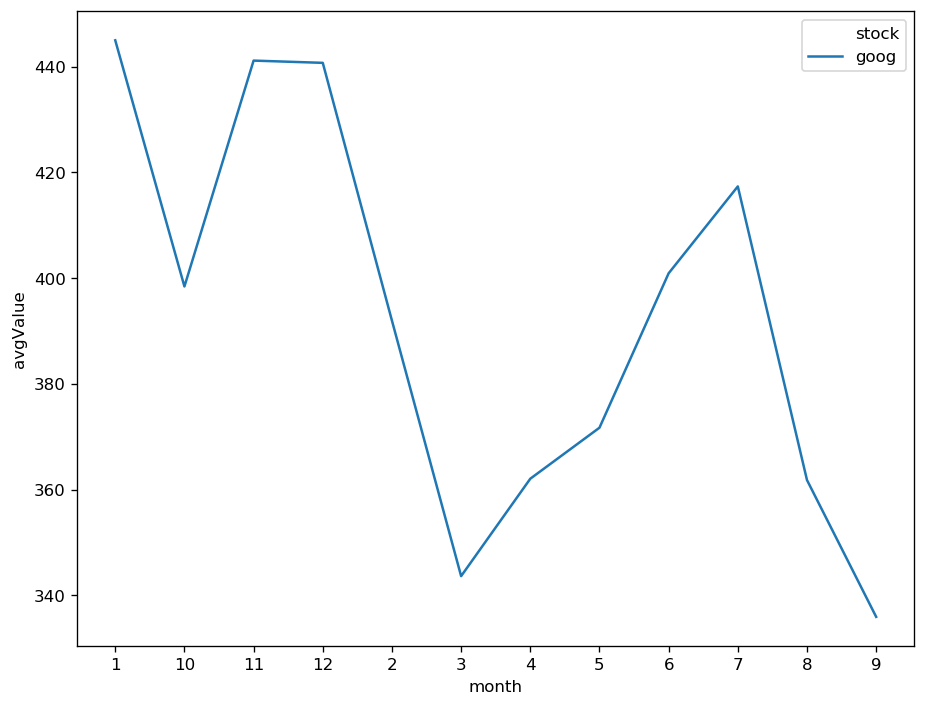

In [24]:
sns.lineplot(x='month', y='avgValue', data=df[df.stock == 'goog'], hue='stock')

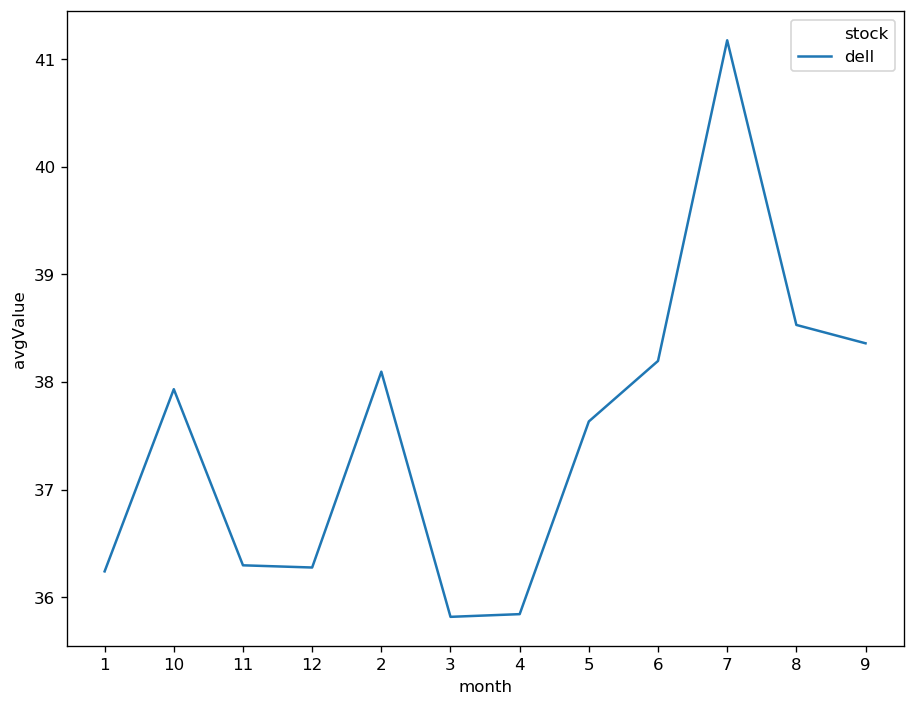

In [25]:
sns.lineplot(x='month', y='avgValue', data=df[df.stock == 'dell'], hue='stock')

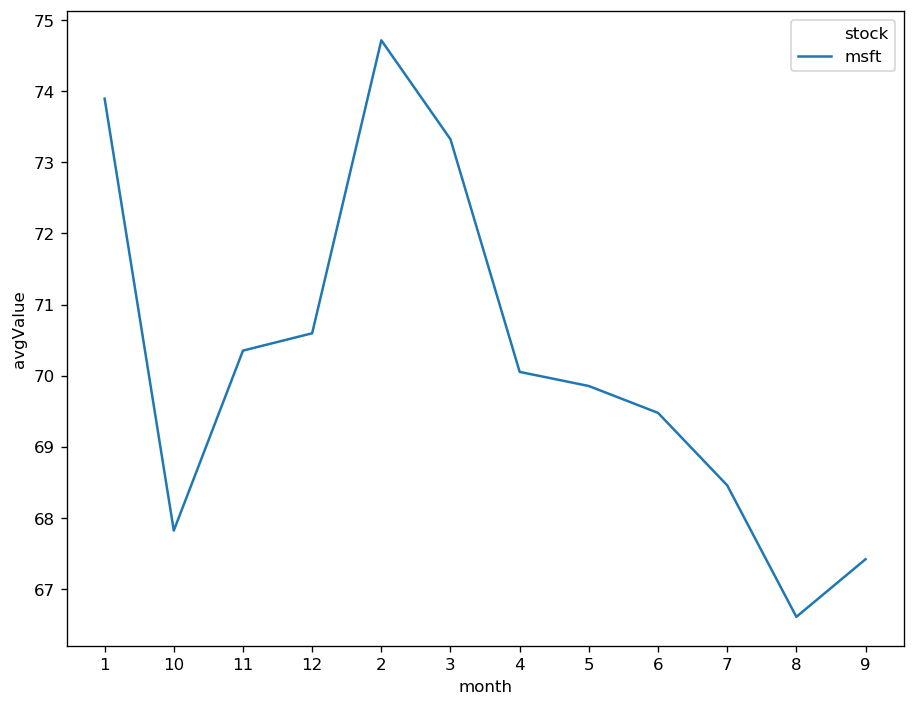

In [26]:
sns.lineplot(x='month', y='avgValue', data=df[df.stock == 'msft'], hue='stock')

As we can see there is quite a bit trend for each month.

We can try day of week, month, year, week number etc.. 

More here, https://docs.mongodb.com/manual/reference/operator/aggregation/